# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur adjoint au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>


## TD6 : Régression bayésienne


La première partie de ce TD est consacrée à la régression Ridge tandis que la deuxième partie du TD est consacrée à l'exploration stochastique des modèles.


In [381]:
using CSV, DataFrames, LinearAlgebra, Statistics, Distributions, Random
using Gadfly

In [382]:
"""
    standardize!(X::AbstractMatrix)

Standardisation du vecteur colonne X ou de chacune des colonnes de la matrice X.

### Arguments
- `X::Matrix{Real}` : Vecteur ou matrice à standardiser.

### Détails

La fonction centre la matrice et modifie l'échelle de l'argument X.

### Exemples

\```
 julia> standardize!(X)
\```

"""
function standardize!(x::Vector{Float64})
    
    x̄ = mean(x)
    s = std(x)
    
    for i=1:length(x)
        x[i] = (x[i] - x̄)/s
    end
    
    return x
    
end

function standardize!(X::Matrix{Float64})
    
    for j=1:size(X,2)
       X[:,j] = standardize!(X[:,j])
    end
    
    return X
    
end

"""
    splitdataframe(df::DataFrame, p::Real)

Partitionne en un ensemble d'entraînement et un ensemble de validation un DataFrame.

### Arguments
- `df::DataFrame` : Un DataFrame
- `p::Real` : La proportion (entre 0 et 1) de données dans l'ensemble d'entraînement.

### Détails

La fonction renvoie deux DataFrames, un pour l'ensemble d'entraînement et l'autre pour l'ensemble de validation.

### Exemple

\```
 julia> splitdataframe(df, .7)
\```

"""
function splitdataframe(df::DataFrame, p::Real)
   @assert 0 <= p <= 1 
    
    n = size(df,1)
    
    ind = shuffle(1:n)
    
    threshold = Int64(round(n*p))
    
    indTrain = sort(ind[1:threshold])
    
    indTest = setdiff(1:n,indTrain)
    
    dfTrain = data[indTrain,:]
    dfTest = data[indTest,:]
    
    return dfTrain, dfTest
    
end

function softmax(x::AbstractVector{<:Real})
    
    z = x .- maximum(x)
    
    e = exp.(z)
    
    s = e ./ sum(e)
    
end

softmax (generic function with 1 method)

## Exercice 1 : Régression Ridge

La régression Ridge est un cas particulier de la régression linéaire bayésienne lorsque la loi *a priori* partiellement informative suivante est utilisée :
$$ f_{(\boldsymbol{\beta},\sigma^2)}(\boldsymbol{\beta},\sigma^2) \propto \mathcal{N}\left(\boldsymbol{\beta} \, \left| \, \boldsymbol{0}_p , \frac{\sigma^2}{\lambda}I_p \right. \right) \times \frac{1}{\sigma^2}. $$
Pour être conséquent avec l'approche bayésienne, il faudrait fixer l'hyperparamètre $\lambda$ avant même d'avoir vu les données. De façon pragmatique, la valeur de $\lambda$ est souvent choisie par validation comme nous le ferons dans cet exercice.

Le jeu de données étudiées provient de l'étude de Tibshirani et al. (2004) illustrant les méthodes de régression modernes telle que la régression Ridge. Nous étudierons la glycémie sanguine (glu) en fonction de 9 variables explicatives : l'âge du patient (age), le sexe du patient (sex), l'indice de masse corporel du patient (bmi), de la tension artérielle moyenne (map) ainsi que de 5 autres indicateur sanguins (tc, ldl, hdl, tch et ltg).


Tibshirani, R. J., Johnstone, I., Hastie, T., & Efron, B. (2004). Least angle regression. The Annals of Statistics, 32(2), 407–499. DOI:10.1214/009053604000000067


In [383]:
# Chargement des données
data = CSV.read("diabetes.csv", copycols=true)
select!(data,Not(:prog))
first(data,5)

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu
,Int64,Int64,Float64,Float64,Int64,Float64,Float64,Float64,Float64,Int64
1,59,1,32.1,101.0,157,93.2,38.0,4.0,2.11,87
2,48,0,21.6,87.0,183,103.2,70.0,3.0,1.69,69
3,72,1,30.5,93.0,156,93.6,41.0,4.0,2.03,85
4,24,0,25.3,84.0,198,131.4,40.0,5.0,2.12,89
5,50,0,23.0,101.0,192,125.4,52.0,4.0,1.86,80


In [384]:
# Prétraitement des données
# Les données sont standardisées

X = convert(Matrix{Float64},data[:,Not(:glu)])
standardize!(X)

y = convert(Vector{Float64}, data[:,:glu])
standardize!(y);


### (a) Estimez les coefficients de régression Ridge en utilisant $\lambda = 10$.

In [385]:
β̂ = (X'*X+λ*I)\X'y;

### (b) Pour $0 \leq \lambda \leq 200$, estimez les coefficients de régression puis affichez-les en fonction de $\lambda$.

Ce graphique s'appelle la trace des coefficients de régression. Lorsqu'il y a multicolinéarité, les estimations des coefficients de régression varient beaucoup en fonction de $\lambda$.

Je vous propose de remplir la matrice $\hat\beta$ constituée de $p$ colonnes. Chaque ligne correspondra aux estimations des coefficients de régression pour une valeur de $\lambda$ donnée. Cette matrice sera par la suite transformée en DataFrame pour un affichage simplifié.

In [386]:
λ = 1:1:200
β̂ = zeros(length(λ),size(X,2))

for i in 1:length(λ)
   
    β̂[i,:] = inv(X'*X+λ[i]*I)*X'*y
    
end

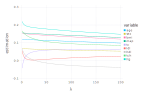

In [387]:
# Création d'un dataframe pour un affichage rapide

varNames = names(data[1,Not(:glu)])

df = convert(DataFrame, β̂)
for i=1:length(varNames)
    rename!(df, Symbol("x$i") => varNames[i])
end

df[!,:λ] = λ

df = stack(df, Not(:λ))
rename!(df, :value => :estimation)

plot(df, x=:λ, y=:estimation, color=:variable, Geom.line)

### (c) Calculez le R² de prévision en utilisant $\lambda=10$.

On rappelle que le R² de prévision s'exprime de la façon suivante :
$$ R^2_{Prev} = 1 - \frac{\sum_{i=1}^n \tilde{e}_i^2}{\sum_{i=1}^n (y_i-\bar{y})^2}. $$

Pour ce faire,
1. Calculez la variabilité totale SST.
2. Estimez les paramètres de la régression Ridge.
3. Obtenez les résidus de la régression Ridge.
4. Calculez les résidus de validation croisée.
5. Calculez le R² de prévision.


In [388]:
λ = 10
SST = sum( (y[i]-ȳ)^2 for i=1:n);

In [389]:
β̂ = (X'*X+λ*I)\X'y;

In [390]:
ϵ = y.-X*β̂;

In [391]:
Hᵣ = X*inv(X'*X+λ*I)*X'
hᵣ = diag(Hᵣ)
ẽ = ϵ./(1 .- hᵣ);

In [392]:
R²ₚ = 1-sum(ẽ[i]^2 for i=1:length(ẽ))/SST

0.9981785563986073

### (d) Calculez le R² de prévision  pour $0 \leq \lambda \leq 200$.

Affichez ensuite le R² de prévision en fonction de λ.

In [393]:
R²ₚ = zeros(200, 1)

for i=1:200
    β̂ = inv(X'*X+i*I)X'*y;
    ϵ = y.-X*β̂;
    Hᵣ = X*inv(X'*X+i*I)*X'
    hᵣ = diag(Hᵣ)
    ẽ = ϵ./(1 .- hᵣ);
    R²ₚ[i] =  1-sum(ẽ[i]^2 for i=1:length(ẽ))/SST
end

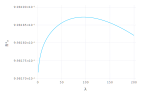

In [394]:
plot(x=1:length(R²ₚ), y=R²ₚ, Geom.line, Guide.xlabel("λ"), Guide.ylabel("R²ₚ"))

### (e) Identifiez la valeur de $\lambda$ qui maximise le R² de prévision

In [395]:
println(mode(R²ₚ))

0.9981717621169426


### (f) Tracez la loi *a posteriori* marginale du coefficient de régression correspond à la variable sexe.

Est-ce que cette variable possède un pouvoir prédictif significatif ? 

Utiliser la commande `LocationScale(μ, sqrt(Σ), TDist(ν))` pour créer un objet de type *loi de Student multidimensionnelle à ν degrés de liberté, de paramètre de localisation μ et de paramètre d'échelle Σ*.

In [396]:
X = X[:,2]; # je pense que oui, la variable sexe a un
# un pouvoir predictif, car elle n'est pas nulle
# dans le graphique de la trace

In [397]:
β̂ = inv(X'*X+λ*I)*X'*y

n = length(y)
p = 9

ν = n
μ = β̂
s² = 1/n*(y-X*β̂)'*(y-X*β̂)
Σ = s²*inv(X'*X+λ*I)

dist = LocationScale(μ, sqrt(Σ), TDist(ν))

LocationScale{Float64,TDist{Float64}}(
μ: 0.2035182890119105
σ: 0.0460053351291713
ρ: TDist{Float64}(ν=442.0)
)


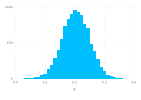

In [398]:
plot( x=rand(dist,10000), Geom.histogram, Geom.histogram(bincount=30))

## Exercice 2 : Exploration stochastique de l'espace des modèles

Dans cet exercice, on reprend le jeux de données *bodyfat.csv* comportant le pourcentage de gras de 20 patientes en fonction des variables explicatives suivantes :

$x_1$ : l'épaisseur des plis de la peau des triceps (en mm) ;<br/>
$x_2$ : le tour de cuisse (en mm) ;<br/>
$x_3$ : la circonférence du bras en (mm).<br/>

Nous allons implémenter l'échantillonnage de Gibbs pour explorer de façon stochastique l'espace des modèele. Puisqu'il n'y a que 3 variables explicatives dans ce cas-ci, il est possible de déterminer quel est le *vrai* meilleur modèle par énumération complète de tous les modèles.


In [399]:
# Chargement des données

data = CSV.read("bodyfat.csv")
first(data, 5)

,Triceps,Thigh,Midarm,Bodyfat
,Float64,Float64,Float64,Float64
1,19.5,43.1,29.1,11.9
2,24.7,49.8,28.2,22.8
3,30.7,51.9,37.0,18.7
4,29.8,54.3,31.1,20.1
5,19.1,42.2,30.9,12.9


In [400]:
# Prétraitement des données

y = data[:,:Bodyfat]
standardize!(y)
X = convert(Matrix{Float64}, data[:,1:3])
standardize!(X)

n, p = size(X)

(20, 3)

In [401]:
# Énumération de tous les modèles possibles

itr = reverse.(Iterators.product(fill(0:1,p)...))[:]

M = BitArray[]
for i in eachindex(itr)
   push!(M, [itr[i]...] .== 1)
end
M

8-element Array{BitArray,1}:
 [0, 0, 0]
 [0, 0, 1]
 [0, 1, 0]
 [0, 1, 1]
 [1, 0, 0]
 [1, 0, 1]
 [1, 1, 0]
 [1, 1, 1]

### (a) Écrivez une fonction permettant de calculer le BIC d'un modèle.

La fonction devrait prendre comme argument un vecteur de booléens indicant quelles variables sont incluses dans le modèle. La fonction devrait prendre en argument par exemple le vecteur [true true true].

In [402]:
λ = 1:1:300
β̂ = zeros(length(λ),size(X,2))

for i in 1:length(λ)
   
    β̂[i,:] = inv(X'*X+λ[i]*I)*X'*y
    
end

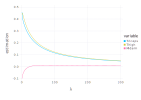

In [403]:
# Création d'un dataframe pour un affichage rapide

varNames = names(data[1,Not(:Bodyfat)])

df = convert(DataFrame, β̂)
for i=1:length(varNames)
    rename!(df, Symbol("x$i") => varNames[i])
end

df[!,:λ] = λ

df = stack(df, Not(:λ))
rename!(df, :value => :estimation)

plot(df, x=:λ, y=:estimation, color=:variable, Geom.line)

In [404]:
R²ₚ = zeros(300, 1)

for i=1:300
    β̂ = inv(X'*X+i*I)X'*y;
    ϵ = y.-X*β̂;
    Hᵣ = X*inv(X'*X+i*I)*X'
    hᵣ = diag(Hᵣ)
    ẽ = ϵ./(1 .- hᵣ);
    R²ₚ[i] =  1-sum(ẽ[i]^2 for i=1:length(ẽ))/SST
end

In [405]:
λ = 200
β̂ = inv(X'*X+λ*I)*X'*y

3-element Array{Float64,1}:
 0.06712636262041434 
 0.07073368820515875 
 0.009172598809706202

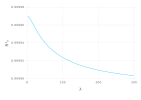

In [406]:
plot(x=1:length(R²ₚ), y=R²ₚ, Geom.line, Guide.xlabel("λ"), Guide.ylabel("R²ₚ"))

In [407]:
mode(R²ₚ)

0.9999695120409754

In [408]:
function getbic(γ::BitArray)
    
    β̂ = inv(X'*X+λ*I)*X'*y

    n = length(y)
    p = 9

    ν = n
    μ = β̂
    s² = 1/n*(y-X*β̂)'*(y-X*β̂)
    Σ = s²*inv(X'*X+λ*I)

    dist = LocationScale(μ, sqrt(Σ), TDist(ν))
    BIC = loglikelihood(dist)
end

getbic (generic function with 1 method)

### (b) Calculer le BIC pour chacun des modèles possibles

Quel est le meilleur modèle ?

### (c) Exécuter la cellule suivante pour parcourir l'espace des modèles avec l'échantillonnage de Gibbs

In [409]:
m = 10000

γ = trues(3,m)

for i=2:m
   γ[:,i] = γ[:,i-1]
    for j=1:p
        
        η₀ = γ[:,i]
        η₁ = γ[:,i]
        η₀[j] = false
        η₁[j] = true
        
#         θ = exp(getbic(η₁)) / ( exp(getbic(η₀)) + exp(getbic(η₁)))
        s = softmax(getbic.([η₀, η₁])) # évite l'instabilité numérique
        θ = s[2]
        
        γ[j,i] = rand(Bernoulli(θ))
        
    end
end

MethodError: MethodError: no method matching LocationScale(::Array{Float64,1}, ::Array{Complex{Float64},2}, ::TDist{Float64})
Closest candidates are:
  LocationScale(!Matched::Integer, !Matched::Integer, ::Distribution{Univariate,Continuous}) at C:\Users\massi\.julia\packages\Distributions\uFI1h\src\univariate\continuous\locationscale.jl:34
  LocationScale(!Matched::T, !Matched::T, ::D; check_args) where {T<:Real, D<:Distribution{Univariate,Continuous}} at C:\Users\massi\.julia\packages\Distributions\uFI1h\src\univariate\continuous\locationscale.jl:29
  LocationScale(!Matched::Real, !Matched::Real, ::D) where D<:Distribution{Univariate,Continuous} at C:\Users\massi\.julia\packages\Distributions\uFI1h\src\univariate\continuous\locationscale.jl:37

### (d) Exécuter les cellules suivantes pour déterminer le modèle choisi pour chacune des itérations

In [410]:
function modelid(M::Vector{BitArray},γ::BitArray)
    
    @assert length(γ)==length(M[1])
    
    ind = 1
    
    while M[ind] != γ
        ind +=1
    end
    
    return ind
        
end

modelid (generic function with 1 method)

In [411]:
id = [modelid(M,γ[:,i]) for i=1:size(γ,2)]

df = DataFrame(Itération = 1:m, Modèle = id)

nb = sort(by(df, :Modèle, nrow), :x1, rev = true)

rename!(nb, :x1 => :Itérations)

,Modèle,Itérations
,Int64,Int64
1,8,10000


### (e) Selon les résultats en (d), quel est le meilleur modèle ? Est-ce cohérent avec le BIC calculé en (a) ?